In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd

In [4]:
import celloracle as co

which: no R in (/ix/djishnu/alw399/envs/bee/bin:/ix/djishnu/alw399/envs/bee/bin:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/condabin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/lib/vscode/bin/remote-cli:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/bin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/bin:/ihome/crc/install/git/2.33.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/b

In [5]:
import sys
sys.path.append('../src')

import numpy as np
from utils import process_adata, filter_clusters

import scanpy as sc 

In [ ]:
# adata = sc.read_h5ad('./.cache/adata_train.h5ad')
# adata

adata = sc.read_h5ad('../data/slideseq/day3_1.h5ad')
adata.obs['rctd_cluster'].value_counts()

In [ ]:
# adata = filter_clusters(adata, c=[5, 6])
adata = process_adata(adata)
adata.shape

In [6]:
# temporary loading until shared adata is consistent

adata = sc.read_h5ad('.cache/adata_train.h5ad')

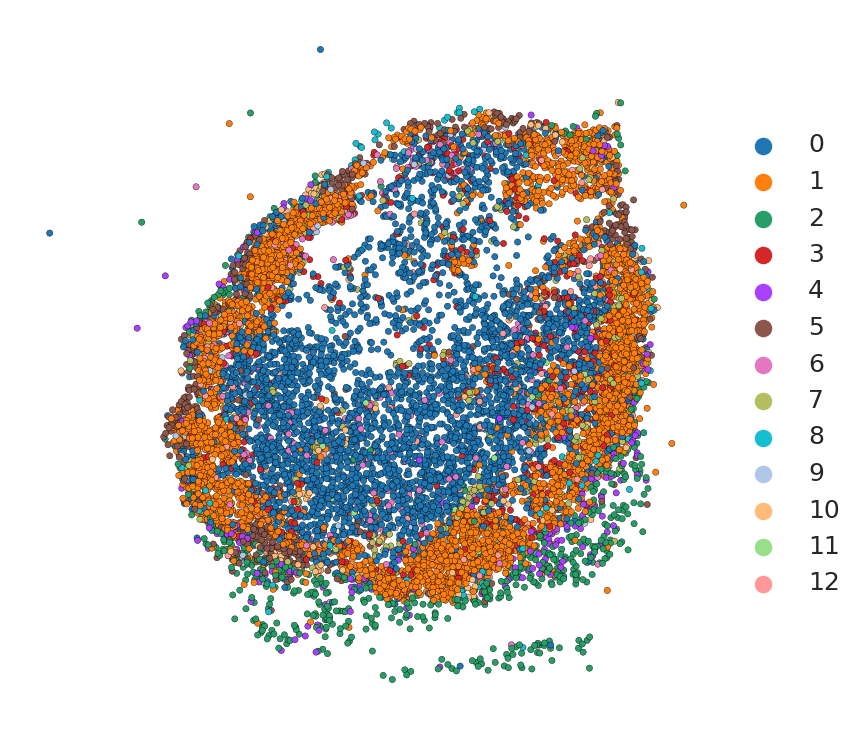

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180
sc.pl.embedding(adata, color='cluster', basis="spatial", s=25, show=False, edgecolor='black', linewidth=0.15)

fig = plt.gcf()
ax = plt.gca()

# # Adjust the legend size
# legend = ax.get_legend()
# for text in legend.get_texts():
#     text.set_fontsize(5)

# for handle in legend.legendHandles:
#     handle._sizes = [15]

plt.title('')
plt.axis('off')
plt.show()

In [8]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

2024-09-11 00:22:22.882462: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 00:22:23.233211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 00:22:23.398718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 00:22:23.427279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-11 00:22:23.650817: I tensorflow/core/platform/cpu_feature_guar

CPU times: user 37.2 s, sys: 4.54 s, total: 41.7 s
Wall time: 40 s


In [9]:
sc.tl.paga(adata, groups='rctd_cluster')

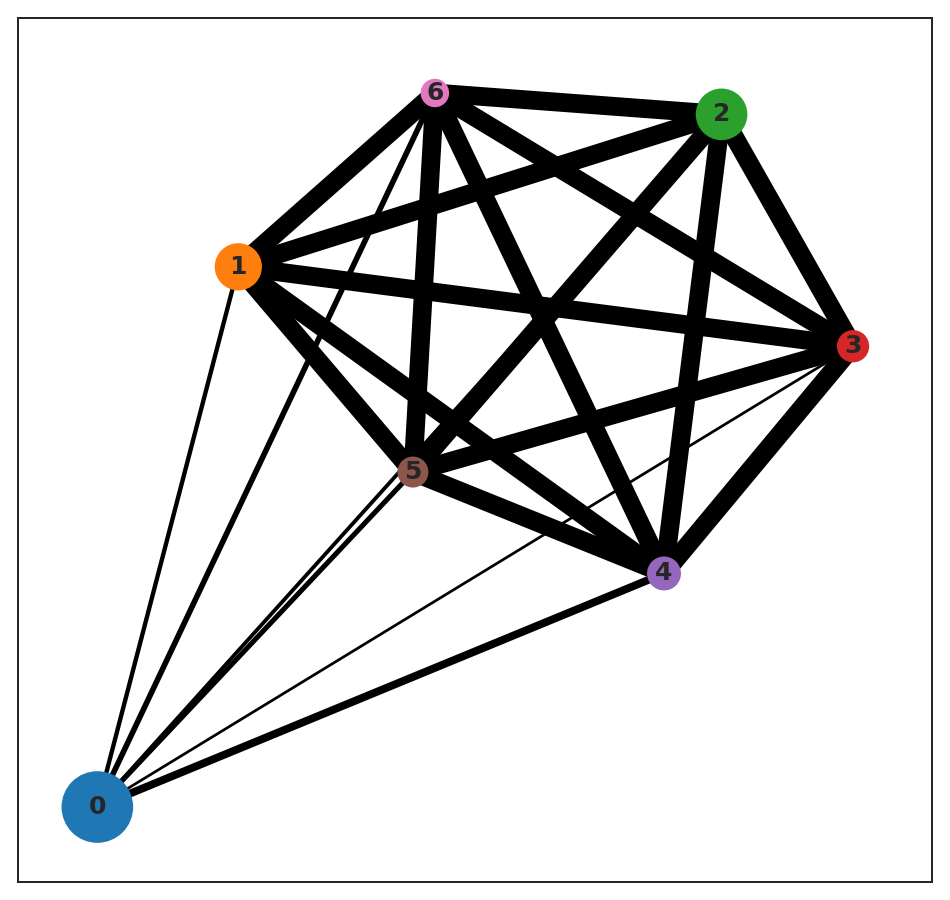

In [10]:
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

In [11]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)

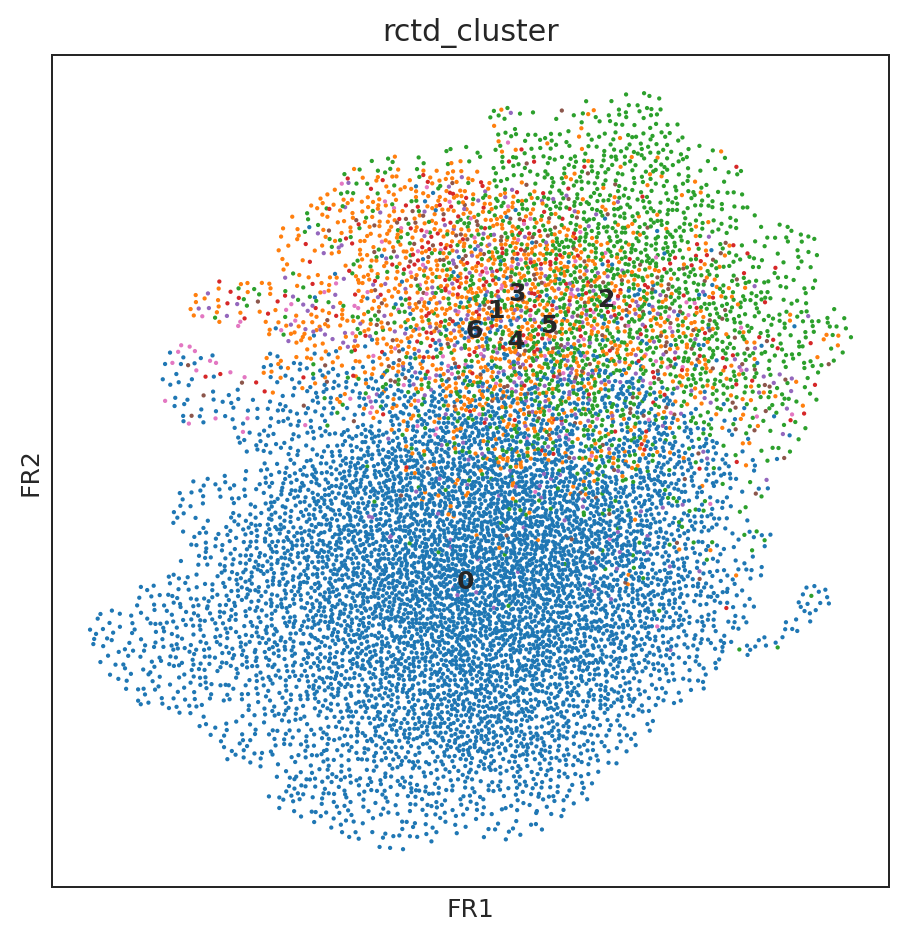

In [12]:
%matplotlib inline
sc.pl.draw_graph(adata, color='rctd_cluster', legend_loc='on data')

In [13]:
oracle = co.Oracle()

In [14]:
adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="rctd_cluster",
    embedding_name="X_draw_graph_fr"
)

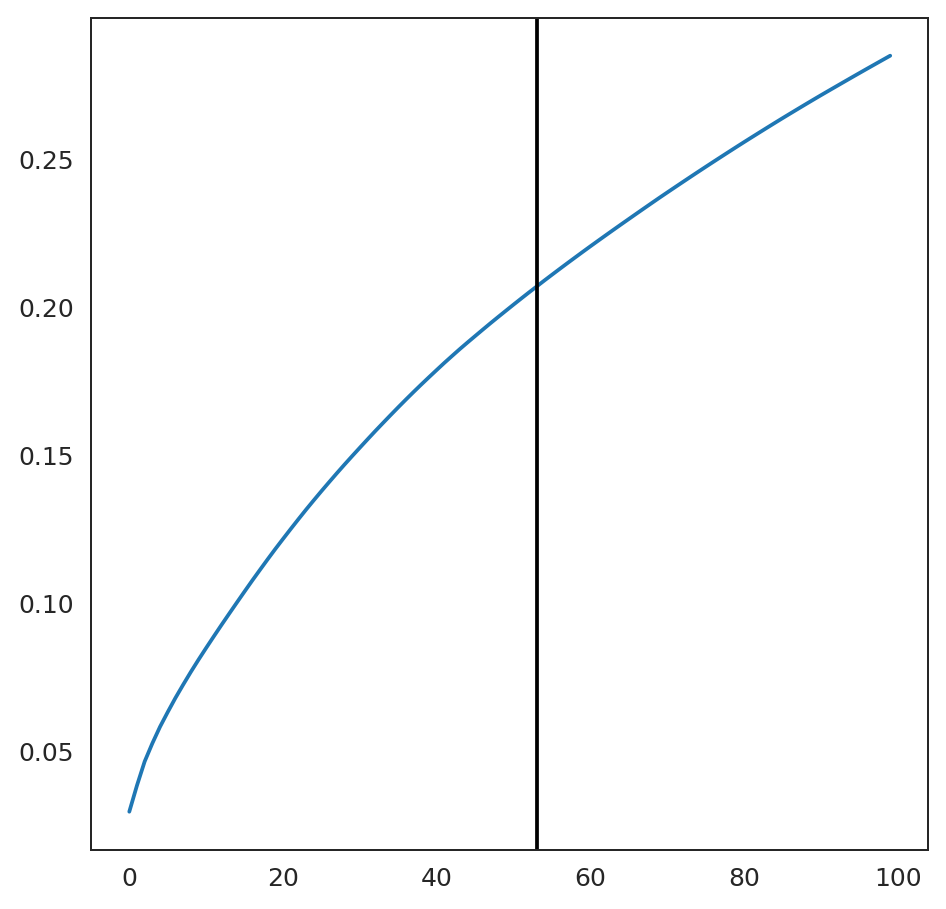

53


In [15]:
%matplotlib inline

# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [16]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :10277


In [17]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :256


In [18]:
# oracle.plot_pca()

In [19]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [20]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [21]:
adata.obsm['X_pca'].shape

(10277, 50)

In [22]:
adata.obs['rctd_cluster'].value_counts()

0    6604
2    1686
1    1155
4     283
3     227
5     191
6     131
Name: rctd_cluster, dtype: int64

In [23]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="rctd_cluster", 
    alpha=10,
    verbose_level=10, 
    # test_mode=True,
    # n_jobs=8
)

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/2363 [00:00<?, ?it/s]

Inferring GRN for 1...


  0%|          | 0/2363 [00:00<?, ?it/s]

Inferring GRN for 2...


  0%|          | 0/2363 [00:00<?, ?it/s]

Inferring GRN for 3...


  0%|          | 0/2363 [00:00<?, ?it/s]

Inferring GRN for 4...


  0%|          | 0/2363 [00:00<?, ?it/s]

Inferring GRN for 5...


  0%|          | 0/2363 [00:00<?, ?it/s]

Inferring GRN for 6...


  0%|          | 0/2363 [00:00<?, ?it/s]

CPU times: user 14min 18s, sys: 16.6 s, total: 14min 34s
Wall time: 18min 40s


In [24]:
links.links_dict[0][links.links_dict[0].p < 0.05].query('target=="Il2"').reset_index(drop=True).sort_values(by='coef_mean', ascending=False)

,source,target,coef_mean,coef_abs,p,-logp
3,Smc3,Il2,0.000306,0.000306,2.516554e-11,10.599194
2,Rest,Il2,0.000092,0.000092,1.028909e-06,5.987623
0,Msc,Il2,0.000060,0.000060,5.174141e-04,3.286162
1,Mga,Il2,0.000036,0.000036,1.589347e-02,1.798781


In [25]:
links.links_dict[0].query('target=="Il2ra"').reset_index(drop=True).sort_values(by='coef_mean', ascending=False)

,source,target,coef_mean,coef_abs,p,-logp
4,Egr1,Il2ra,0.005437,0.005437,4.054389e-17,16.392075
10,Runx2,Il2ra,0.001265,0.001265,1.712339e-14,13.766410
6,Foxn3,Il2ra,0.001219,0.001219,1.436436e-08,7.842714
5,Taf1,Il2ra,0.000870,0.000870,2.692242e-09,8.569886
1,Hivep1,Il2ra,0.000546,0.000546,5.786059e-12,11.237617
2,Foxj3,Il2ra,0.000377,0.000377,4.954053e-10,9.305039
8,Zbtb6,Il2ra,0.000213,0.000213,1.899755e-06,5.721302
12,Rxra,Il2ra,0.000189,0.000189,9.266863e-03,2.033067
7,Nfkb2,Il2ra,0.000188,0.000188,2.346842e-03,2.629516
16,Gtf3c2,Il2ra,0.000119,0.000119,1.801501e-05,4.744366


In [26]:
import pickle

with open('../data/slideseq/celloracle_links_day3_1.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)


In [27]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
with open('../data/slideseq/celloracle_coefs_day3_1.pkl', 'wb') as f:
    pickle.dump(oracle.coef_matrix_per_cluster, f)